# COBAR 2023 Locomotion Code Submission

Please use this template to submit your code for your COBAR miniproject.

**PLEASE READ THE INSTRUCTIONS BELOW CAREFULLY.**

**Google Colab:** It is your responsibility to make sure that your code can be executed without error on Google Colab. You may use your own machine for development, but in the end we will use Colab to determine whether your code runs. You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."

**Where to put your code:** Please only fill your code in places indicated by the following. These cells are provided flexibly enough, and you should be able to easily add your custom import/loading/preprocessing/stepping code. You may also use common `*.py` module files and import functions/classes from these modules.
```Python
# ========== YOUR CODE BELOW ==========
... write your code here
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
```

**Terrain types:** Once you have completed this notebook for flat terrain, duplicate 2 more copies of this notebook, and change the terrain type to "gapped" and "blocks" respectively. Make sure you can run all three notebooks on Colab.

**Stabilization time:** Recall from the decentralized control demo: it might be helpful to first run a number of steps (`n_steps_stabil`) without locomotion so the fly has a chance to stabilize on the ground. This is allowed and does not count toward the 1-second simulation time.

**What to submit:** Please submit the following files via Moodle:
1. The three *executed* notebooks (ie. the outputs of the code blocks are printed). Name these files "submission_flat.ipynb", "submission_gapped.ipynb", and "submission_blocks.ipynb"
2. The three output videos: "output_flat.mp4", "output_gapped.mp4", and "output_blocks.mp4"
3. Any data file that are required for the notebooks to run (eg. parameter files, additional configurations, ...). In other words, include any file that you are loading to the notebooks. We will download these files to the same directory/folder as the notebook files before running the notebooks.
4. If you have any `*.py` module file from which you imported variables, functions, or classes, included these files too.

---

In [1]:
# #@title Install `flygym` on Colab

# # This block is modified from dm_control's tutorial notebook
# # https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    print('Installing flygym')
    !pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during dm_control installation. Check the shell '
            'output above for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    print('Checking that the flygym installation succeeded...')
    try:
        import flygym
        from flygym import envs
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during flygym installation. Check the shell '
            'output above for more information.\n')
    else:
        del envs, flygym
else:
    print('Skipping - not on Colab')

Skipping - not on Colab


You may install any additional packages here with pip. NumPy should already be installed; it's merely a demonstration of the syntax.

In [2]:
# ========== YOUR CODE BELOW ==========
!pip install numpy
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

The following are some of the modules imported in the demo notebooks:

In [3]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

You may import any additional modules here:

In [4]:
# ========== YOUR CODE BELOW ==========
from scipy.integrate import ode
from flygym.util.config import all_tarsi_collisions_geoms
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

We select the terrain type here. **YOUR CODE MUST STILL WORK IF THIS IS CHANGED TO gapped OR blocks!**

In [5]:
terrain_type = 'gapped'  # or 'gapped' or 'blocks'

We define some other physics parameters. Thess must not be changed.

In [6]:
# You are allowed to slightly change the initial position of the fly
# if it immediately gets stuck due to unfortunate initial placement
# ========== YOUR CODE BELOW ==========
fly_pos = (0, 0, 300)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

run_time = 1
out_dir = Path(f'contest_submission_{terrain_type}')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': fly_pos,
                  'friction': (friction, 0.005, 0.0001)}

You may load any preprogrammed data here and manipulate them as needed. This can include reference step kinematics (as used in the decentralized control and centralized control notebooks), or parameter files for your artificial neural network:

In [7]:
# ========== YOUR CODE BELOW ==========

# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

Next, initiate your NeuroMechFly simulation environment.

In [8]:
# ========== YOUR CODE BELOW ==========
nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         terrain_config=terrain_config,
                         terrain='gapped')
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

You can add arbitrary code here after initializing the `nmf` object and before running the simulation loop:

In [9]:
# ========== YOUR CODE BELOW ==========
np.random.seed(42)

num_steps_base = int(run_time / nmf.timestep)

dt = nmf.timestep  # seconds
t = np.arange(0, run_time, dt)

legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
tarsus_5_indices = np.array([4, 9, 14, 19, 24, 29])

n_oscillators = len(legs)

# We want 10 oscillations in the time period
n_steps = 10
frequencies = np.ones(n_oscillators) * n_steps / run_time

# Each oscillator has the same amplitude
target_amplitude = 1.0
target_amplitudes = np.ones(n_oscillators) * target_amplitude

rate = 10
rates = np.ones(n_oscillators) * rate

def phase_oscillator(_time, state, frequencies, coupling_weights, phase_biases, contact_forces, prev_contact_forces):
    """Phase oscillator model used in Ijspeert et al. 2007"""
    
    phases = state[:n_oscillators]
    amplitudes = state[n_oscillators:2*n_oscillators]

    # NxN matrix with the phases of the oscillators
    phase_matrix = np.tile(phases, (n_oscillators, 1))

    # NxN matrix with the amplitudes of the oscillators
    amp_matrix = np.tile(amplitudes, (n_oscillators, 1))

    freq_contribution = 2*np.pi*frequencies

    # scaling of the phase differences between oscillators by the amplitude of the oscillators and the coupling weights
    scaling = np.multiply(amp_matrix, coupling_weights)

    # phase matrix and transpose substraction are analogous to the phase differences between oscillators, those should be close to the phase biases
    phase_shifts_contribution = np.sin(phase_matrix - phase_matrix.T - phase_biases)

    # Here we compute the contribution of the phase biases to the derivative of the phases
    # we mulitply two NxN matrices and then sum over the columns (all j oscillators contributions) to get a vector of size N 
    coupling_contribution = np.sum(np.multiply(scaling, phase_shifts_contribution), axis=1)

    # Here we compute the contribution of the contact forces to the derivative of the phases
    forces_coeff = 0.001
    forces_contribution = forces_coeff * (contact_forces - prev_contact_forces)

    # Here we compute the derivative of the phases given by the equations defined previously. 
    # We are using for that matrix operations to speed up the computation
    dphases =  freq_contribution + coupling_contribution - forces_contribution
    
    damplitudes = np.multiply(rates, target_amplitudes-amplitudes)
    
    return np.concatenate([dphases, damplitudes])

def sine_output(phases, amplitudes):
        return amplitudes * (1 + np.cos(phases))

# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
step_data_block_base = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])

step_data_block_manualcorrect = step_data_block_base.copy()
for side in ["L", "R"]:
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}MCoxa")] += np.deg2rad(10) # Protract the midlegs
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HFemur")] += np.deg2rad(-5) # Retract the hindlegs
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (also helps with the hindleg retraction)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FFemur")] += np.deg2rad(15) # Protract the forelegs (slightly to conterbalance Tarsus flexion)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (add some retraction of the forelegs)

n_joints = len(nmf.actuated_joints)

leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

def advancement_transfer(phases, step_dur=interp_step_duration):
    """From phase define what is the corresponding timepoint in the joint dataset
    In the case of the oscillator, the period is 2pi and the step duration is the period of the step
    We have to match those two"""

    period = 2*np.pi
    #match length of step to period phases should have a period of period mathc this perios to the one of the step
    t_indices = np.round(np.mod(phases*step_dur/period, step_dur-1)).astype(int)
    t_indices = t_indices[match_leg_to_joints]
    
    return t_indices

# The bias matrix is define as follow: each line is the i oscillator and each column is the j oscillator couplign goes from i to j
# We express the bias in percentage of cycle 

phase_biases_measured_tripod_gait= np.array([[0, 0.425, 0.85, 0.51, 0, 0],
                                             [0.425, 0, 0.425, 0, 0.51, 0],
                                             [0.85, 0.425, 0, 0, 0, 0.51],
                                             [0.51, 0, 0, 0, 0.425, 0.85],
                                             [0, 0.51, 0, 0.425, 0, 0.425],
                                             [0, 0, 0.51, 0.85, 0.425, 0]])
                                
phase_biases_idealized_tripod_gait = np.array([[0, 0.5, 1.0, 0.5, 0, 0],
                                               [0.5, 0, 0.5, 0, 0.5, 0],
                                               [1.0, 0.5, 0, 0, 0, 0.5],
                                               [0.5, 0, 0, 0, 0.5, 1.0],
                                               [0, 0.5, 0, 0.5, 0, 0.5],
                                               [0, 0, 0.5, 1.0, 0.5, 0]])

phase_biases_idealized_caterpillar_gait = np.array([[0, 2/3, 1/3, 0, 2/3, 1/3],
                                                    [1/3, 0, 2/3, 1/3, 0, 2/3],
                                                    [2/3, 1/3, 0, 2/3, 1/3, 0],
                                                    [0, 2/3, 1/3, 0, 2/3, 1/3],
                                                    [1/3, 0, 2/3, 1/3, 0, 2/3],
                                                    [2/3, 1/3, 0, 2/3, 1/3, 0]])
# Phase bias of one is the same as zero (1 cycle difference)
# If we would use a phase bias of zero, we would need to change the coupling weight strategy

phase_biases = phase_biases_idealized_caterpillar_gait * 2 * np.pi

coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

Now, run the simulation:

In [10]:
# Final preparation here
# ========== YOUR CODE BELOW ==========
# Set solver and initial values
solver = ode(f=phase_oscillator)
solver.set_integrator('dop853')
initial_values = np.random.rand(2*n_oscillators)
solver.set_initial_value(y=initial_values, t=nmf.curr_time)

n_stabilisation_steps = 1000
num_steps = n_stabilisation_steps + num_steps_base

prev_phase = None
prev_amp = None
contact_forces = None
prev_contact_forces = None
obs = None
phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))
joint_angles = np.zeros((num_steps, n_joints))

# Logging
x_pos_hist = []
y_pos_hist = []
side_stability_hist = []
forward_backward_stability_hist = []
pitch_hist = []
roll_hist = []
reward_hist = []
raw_obs_hist = []
def get_delta_forces_side_stability(raw_obs):
    legs_side_ordered = ["RF", "RM", "RH", "LF", "LM", "LH"]
    legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
    leg_force_sensors_ids = {leg:[] for leg in legs}
    for i, collision_geom in enumerate(all_tarsi_collisions_geoms):
        for leg in legs:
            if collision_geom.startswith(leg+"Tarsus"):
                leg_force_sensors_ids[leg].append(i)
    leg_contact_forces = np.array([np.sum(raw_obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs_side_ordered])
    delta_forces = np.sum(leg_contact_forces[:3])/3 - np.sum(leg_contact_forces[3:])/3
    return delta_forces

def get_delta_forces_forward_backward_stability(raw_obs):
    legs_forward_ordered = ["RF", "LF", "RH", "LH"]
    legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
    leg_force_sensors_ids = {leg:[] for leg in legs}
    for i, collision_geom in enumerate(all_tarsi_collisions_geoms):
        for leg in legs:
            if collision_geom.startswith(leg+"Tarsus"):
                leg_force_sensors_ids[leg].append(i)
    leg_contact_forces = np.array([np.sum(raw_obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs_forward_ordered])
    delta_forces = np.sum(leg_contact_forces[:2])/2 - np.sum(leg_contact_forces[2:])/2
    return delta_forces
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

nmf.reset()
x_pos_hist = []

# Main simulation loop
for i in trange(num_steps):
    # You may insert any code before stepping the physics simulation...
    # ========== YOUR CODE BELOW ==========
    frequencies = np.ones(n_oscillators) * n_steps / run_time

    # First mechanism to integrate sensory feedback
    if obs is not None:
        # Step 1: Retrieve contact forces
        contact_forces = obs['contact_forces'][tarsus_5_indices]
        # Step 2: Find leg with the most force
        max_force_index = contact_forces.argmax()
        # Step 3: Find leg with less force
        min_force_index = contact_forces.argmin()
        # Step 4: Calculate scaling factors
        scaling_factors = []
        max_force = contact_forces[max_force_index]
        min_force = contact_forces[min_force_index]
        for j in range(len(legs)):
            if j == max_force_index:
                scaling_factors.append(0.5)
            elif j == min_force_index:
                scaling_factors.append(1.5)
            else:
                delta_f = max_force - min_force
                leg_diff = contact_forces[j] - min_force
                if delta_f == 0:
                    scaling_factor = 1
                else:
                    scaling_factor = 0.5 + 1.0 * (leg_diff / delta_f)
                scaling_factors.append(scaling_factor)
        # Step 5: Apply scaling factors to frequencies
        frequencies = np.array([freq * scaling_factors[j] for j, freq in enumerate(frequencies)])

    # Pass the various parameters to the solver
    if contact_forces is None:
        contact_forces = np.zeros(n_oscillators)
        prev_contact_forces = np.zeros(n_oscillators)
    solver.set_f_params(frequencies, coupling_weights, phase_biases, contact_forces, prev_contact_forces)
    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    prev_contact_forces = contact_forces.copy()

    """
    # Second mechanism to integrate sensory feedback
    force_threshold = 500.0
    sudden_force_indices = np.where(contact_forces > force_threshold)[0]
    # The phase and amplitude of the oscillators that have a contact force above the threshold are frozen
    for index in sudden_force_indices:
        if prev_phase is not None:
            phase[index] = prev_phase[index]
        if prev_amp is not None:
            amp[index] = prev_amp[index]
    """

    prev_phase = phase.copy()
    prev_amp = amp.copy()

    phases[i, :] = phase
    amplitudes[i, :] = amp 

    if i> n_stabilisation_steps:
        indices = advancement_transfer(phase)
        # scale the amplitude of the joint angles to the output amplitude (High values of amplitude will highly alter the steps) 
        # With an amplitude of one, the joint angles will be the same as the one from the base step
        # With an amplitude of zero, the joint angles will be the same as the zero inidices of the base step (default pose)
        # The rest is a linear interpolation between those two
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0] + \
                   (step_data_block_manualcorrect[joint_ids, indices]-step_data_block_manualcorrect[joint_ids, 0])*amp[match_leg_to_joints]}
    else:
        # During the stabilisation phase, we use the base step
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}

    joint_angles[i, :] = action['joints']
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    obs, info = nmf.step(action)
    nmf.render()
    
    # ... and after stepping the physics simulation
    # ========== YOUR CODE BELOW ==========
    
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    # Report the final x position of the base of the fly here. If you wrote
    # a wrapper around `NeuroMechFlyMuJoCo` (for your own RL pipeline, for
    # example), you may modify the code below to faithfully report the final
    # x position of the base of the fly depending on your implementation.
    # Obviously, don't hard code a very large number :)
    # ========== YOUR CODE BELOW ==========
    current_x_pos = obs['fly'][0, 0]
    y_pos_hist.append(obs['fly'][0, 1])
    side_stability = get_delta_forces_side_stability(obs)
    side_stability_hist.append(side_stability)
    forward_backward_stability = get_delta_forces_forward_backward_stability(obs)
    forward_backward_stability_hist.append(forward_backward_stability)
    pitch_hist.append(obs['fly'][2, 1])
    roll_hist.append(obs['fly'][2, 0])
    raw_obs_hist.append(obs)
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    x_pos_hist.append(current_x_pos)

# Save video here. SUBMIT THIS VIDEO ALONG WITH THE CODE!
nmf.save_video(out_dir / f"output_{terrain_type}.mp4")

nmf.close()


  0%|          | 0/11000 [00:00<?, ?it/s]c:\Users\Luca\miniconda3\envs\flygym\lib\site-packages\scipy\integrate\_ode.py:1179: UserWarning: dop853: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
100%|██████████| 11000/11000 [01:02<00:00, 175.29it/s]


The video should have been saved to `out_dir / f"output_{terrain_type}.mp4"`. Check that it makes sense.

Finally, let's visualize how the fly's x position changes over time:

Final X position: 4.5493 mm
Final Y position: 0.1644 mm


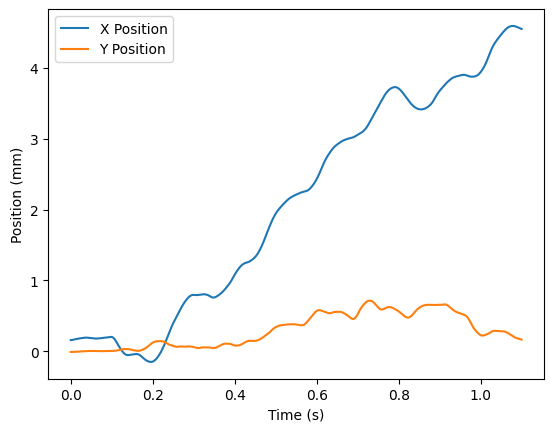

In [11]:
# Plot of the X-Y position of the fly over time
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(x_pos_hist) / 1000)
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(y_pos_hist) / 1000)
plt.xlabel('Time (s)')
plt.ylabel('Position (mm)')
plt.legend(labels=['X Position', 'Y Position'])
print(f'Final X position: {x_pos_hist[-1] / 1000:.4f} mm')
print(f'Final Y position: {y_pos_hist[-1] / 1000:.4f} mm')

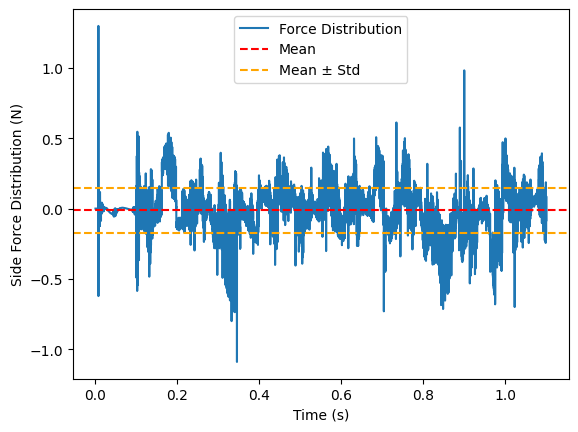

In [12]:
# Plot of the side force distribution
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(side_stability_hist)/1000)
plt.xlabel('Time (s)')
plt.ylabel('Side Force Distribution (N)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(side_stability_hist)/1000)
std = np.std(np.array(side_stability_hist)/1000)
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Force Distribution', 'Mean', 'Mean ± Std'])
# Display the plot
plt.show()

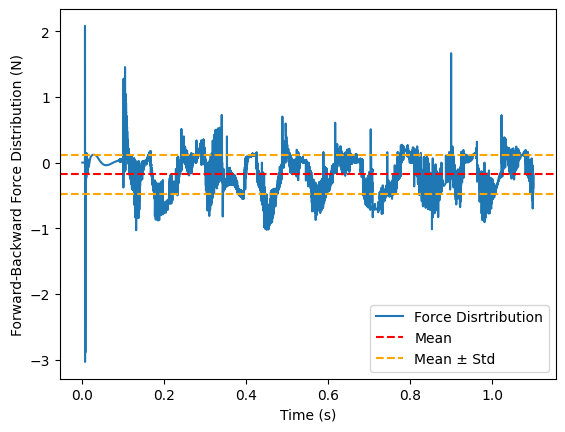

In [13]:
# Plot of the forward-backwards force distribution
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(forward_backward_stability_hist)/1000)
plt.xlabel('Time (s)')
plt.ylabel('Forward-Backward Force Distribution (N)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(forward_backward_stability_hist)/1000)
std = np.std(np.array(forward_backward_stability_hist)/1000)
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Force Disrtribution', 'Mean', 'Mean ± Std'])
plt.show()

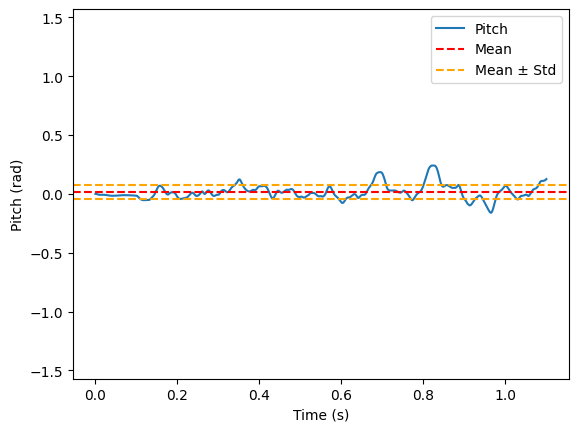

In [14]:
# Plot of the pitch of the fly over time
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(pitch_hist))
plt.xlabel('Time (s)')
plt.ylabel('Pitch (rad)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(pitch_hist))
std = np.std(np.array(pitch_hist))
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Pitch', 'Mean', 'Mean ± Std'])
plt.ylim(-3.14/2, 3.14/2)
# Display the plot
plt.show()

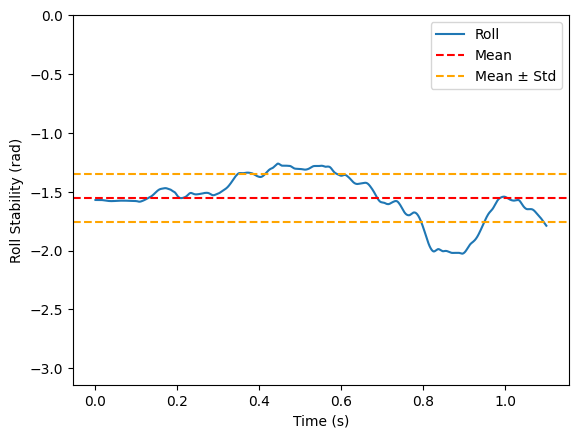

In [15]:
# Plot of the roll of the fly over time
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(roll_hist))
plt.xlabel('Time (s)')
plt.ylabel('Roll Stability (rad)')
# Calculate the mean and standard deviation
mean = np.mean(np.array(roll_hist))
std = np.std(np.array(roll_hist))
# Plot the mean with a dashed red line
plt.axhline(mean, color='red', linestyle='dashed')
plt.axhline(mean - std, color='orange', linestyle='dashed')
plt.axhline(mean + std, color='orange', linestyle='dashed')
# Add legend
plt.legend(labels=['Roll', 'Mean', 'Mean ± Std'])
plt.ylim(-3.14, 0)
# Display the plot
plt.show()

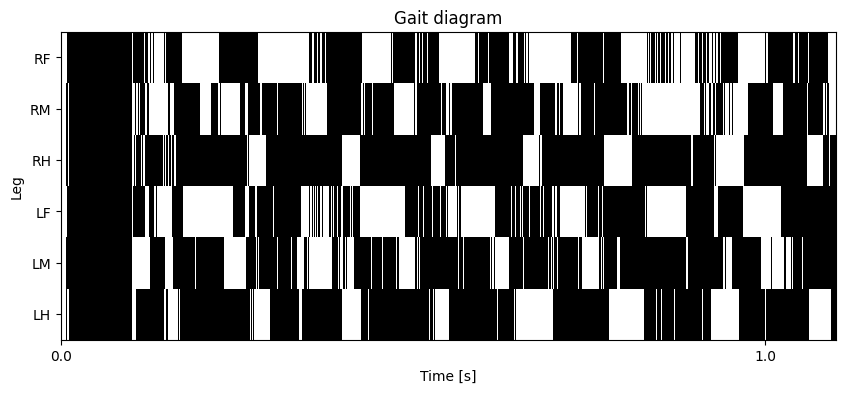

In [16]:
# Plot of the gait diagram
# Build an where lines are legs, columns are timepoint and there is a one in the array if the left leg is in contact with the ground
# and a zero if it is not
all_legs_contact = np.zeros((len(legs), num_steps))
gait_diagram_leg_order = ["RF", "RM", "RH", "LF", "LM", "LH"]
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(all_tarsi_collisions_geoms):
    for leg in legs:
        if collision_geom.startswith(leg+"Tarsus"):
            leg_force_sensors_ids[leg].append(i)
assert set(gait_diagram_leg_order) == set(legs)
for t in range(num_steps):
    for l, leg in enumerate(gait_diagram_leg_order):
        all_legs_contact[l, t] = np.sum(raw_obs_hist[t]["contact_forces"][leg_force_sensors_ids[leg]]) > 0
# plot the gait diagram leg vs time; Should appear black if the leg is in contact with the ground
# median filter the contat to smooth the gait diagram
from scipy.signal import medfilt
t_ids = np.arange(0, num_steps, 1)
time = t_ids * nmf.timestep
plt.figure(figsize=(10, 4))
all_legs_contact_smooth = medfilt(all_legs_contact, kernel_size=(1, 3))
plt.imshow((np.logical_not(all_legs_contact_smooth)), cmap="gray", aspect="auto", interpolation="none")
plt.xlabel("Time [s]")
plt.ylabel("Leg")
plt.yticks(np.arange(len(legs)), gait_diagram_leg_order)
plt.xticks(t_ids[::10000], time[::10000])
plt.title("Gait diagram")
plt.show()